In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import time


In [ ]:
# output_path = "semantic_drift/cathy_4_distill_ti_v1_batch64_w0.0"
# output_path = "semantic_drift/celebA_342_distill_ti_v1_batch64_w0.0/prompts/prompt_test_man"
output_path = "semantic_drift/celebA_342_ti/prompts/prompt_test_man"
save_path = "results/celebA_342_ti/prompts/prompt_test_man"
exp_name = "celebA_342_ti"
prompt_name = "prompt_test_man"
prompt_file = "prompts/prompt_test_man.csv"

# output_path = "semantic_drift/celebA_342_ti/prompts/gen_prompt_actions"
# save_path = "results/celebA_342_ti/prompts/gen_prompt_actions"
# exp_name = "celebA_342_ti"
# prompt_name = "gen_prompt_actions"
# prompt_file = "prompts/gen_prompt_actions.csv"

# output_path = "semantic_drift/cat_toy_ti/prompts/prompt_test_toy"
# save_path = "results/cat_toy_ti/prompts/prompt_test_toy"
# exp_name = "cat_toy_ti"
# prompt_name = "prompt_test_toy"

reference_embeddings_path = output_path + "/reference_embeddings.pt"
reference_embeddings = torch.load(reference_embeddings_path, map_location=torch.device('cuda'))

dict_embeddings_path = output_path + "/dict_embeddings.pt"
dict_embeddings = torch.load(dict_embeddings_path, map_location=torch.device('cuda'))

print(dict_embeddings.keys())

replaced_embeddings = {}
replaced_embeddings[r'$V^*$'] = torch.load("semantic_drift/{}/prompts/{}/dict_embeddings.pt".format(exp_name, prompt_name), map_location=torch.device('cuda'))

# if exp_name == "celebA_342_ti":
#     replaced_embeddings["banana"] = torch.load("semantic_drift/{}_replaced_by_banana/prompts/{}/dict_embeddings.pt".format(exp_name, prompt_name), map_location=torch.device('cuda'))
#     replaced_embeddings["toy"] = torch.load("semantic_drift/{}_replaced_by_toy/prompts/{}/dict_embeddings.pt".format(exp_name, prompt_name), map_location=torch.device('cuda'))
#     replaced_embeddings["bus"] = torch.load("semantic_drift/{}_replaced_by_bus/prompts/{}/dict_embeddings.pt".format(exp_name, prompt_name), map_location=torch.device('cuda'))
#     replaced_embeddings["woman"] = torch.load("semantic_drift/{}_replaced_by_woman/prompts/{}/dict_embeddings.pt".format(exp_name, prompt_name), map_location=torch.device('cuda'))
#     replaced_embeddings["man"] = torch.load("semantic_drift/{}_replaced_by_man/prompts/{}/dict_embeddings.pt".format(exp_name, prompt_name), map_location=torch.device('cuda'))

simple_prompt_embeddings = torch.load("semantic_drift/{}/prompts/prompt_man_simple_v2/dict_embeddings.pt".format(exp_name), map_location=torch.device('cuda'))


from utils import read_prompt_file

prompts_data = read_prompt_file(prompt_file)


/tmp/ipykernel_2447245/565771878.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reference_embeddings = torch.load(reference_embeddings_path, map_location=torch.device(

dict_keys([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000])


/tmp/ipykernel_2447245/565771878.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  replaced_embeddings[r'$V^*$'] = torch.load("semantic_drift/{}/prompts/{}/dict_embedding

AssertionError: Prompt file prompts/prompt_test_man.csv does not contain {}

In [3]:
def dist_average(x, batch):
    # Computes the average distance between 
    # x and all points in batch
    return torch.mean(torch.norm(x - batch, dim=1), dim=0)

def dist_average_all(x, batch):
    # Computes the average distance between 
    # x and all points in batch
    x = x.unsqueeze(1) # shape [x_size, 1, dim]
    batch = batch.unsqueeze(0) # shape [1, batch_size, dim]
    res = torch.norm(x - batch, dim=2) # shape [x_size, batch_size]
    assert res.shape == (x.shape[0], batch.shape[1]), f"res.shape: {res.shape}, x.shape: {x.shape}, batch.shape: {batch.shape}"
    return torch.mean(res, dim=1) # shape [x_size]

def dist_minimum_distance(x, batch):
    # Computes the minimum distance between 
    # x and all points in batch
    return torch.min(torch.norm(x - batch, dim=1), dim=0)

def dist_maximum_similarity(x, batch):
    # Computes the maximum similarity between 
    # x and all points in batch using cosine similarity
    assert len(x.shape) == 1, f"x.shape: {x.shape}"
    assert len(batch.shape) == 2, f"batch.shape: {batch.shape}"
    x = x.unsqueeze(0)
    sim = torch.nn.functional.cosine_similarity(x, batch, dim=1)
    return torch.max(sim)

def dist_hausdorff(x, batch):
    pass

def dist_hausdorff_batch(xes, batch):
    # Computes the Hausdorff distance between 
    # d_H(P, Q) = \max( \max_{p_i \in P} \min_{q_j \in Q} d_{L2}(p_i, q_j), \max_{q_i \in Q} \min_{p_j \in P} d_{L2}(q_i, p_j) )
    assert len(xes.shape) == 2
    assert len(batch.shape) == 2

    xes = xes.unsqueeze(1)  # Shape: [xes_size, 1, dim]
    batch = batch.unsqueeze(0)  # Shape: [1, batch_size, dim]
    
    # Calculate pairwise L2 distances between all points
    # Shape: [xes_size, batch_size]
    pairwise_distances = torch.norm(xes - batch, dim=2)
    
    # For each point in xes, find the minimum distance to any point in batch
    # Shape: [xes_size]
    min_distances_xes_to_batch = torch.min(pairwise_distances, dim=1)[0]
    
    # For each point in batch, find the minimum distance to any point in xes
    # Shape: [batch_size]
    min_distances_batch_to_xes = torch.min(pairwise_distances, dim=0)[0]
    
    # Find the maximum of the minimum distances for both directions
    max_min_xes_to_batch = torch.max(min_distances_xes_to_batch)
    max_min_batch_to_xes = torch.max(min_distances_batch_to_xes)
    
    # Hausdorff distance is the maximum of these two values
    hausdorff_distance = torch.max(max_min_xes_to_batch, max_min_batch_to_xes)
    
    return hausdorff_distance


def dist_hausdorff_intra(xes):
    """
    Computes the intra-Hausdorff distance of a batch:
    max_i min_{j ≠ i} ||x_i - x_j||_2

    Args:
        xes (torch.Tensor): Tensor of shape (N, D)

    Returns:
        torch.Tensor: Scalar Hausdorff distance
    """
    assert len(xes.shape) == 2
    N, D = xes.shape

    # Compute full pairwise distance matrix: shape (N, N)
    diff = xes.unsqueeze(1) - xes.unsqueeze(0)  # (N, N, D)
    dist_matrix = torch.norm(diff, dim=2)       # (N, N)

    # Mask out the diagonal (self-distances)
    mask = torch.eye(N, dtype=torch.bool, device=xes.device)
    dist_matrix.masked_fill_(mask, float('inf'))

    # For each point, get its nearest neighbor distance
    min_dists = torch.min(dist_matrix, dim=1)[0]  # (N,)

    # Hausdorff distance: max over all these min distances
    return torch.max(min_dists)


def dist_infoNCE(x, batch, temperature=1.0):
    # Computes the InfoNCE distance between 
    # x and all points in batch
    assert len(x.shape) == 1
    assert len(batch.shape) == 2
    x = x.unsqueeze(0)
    sim = torch.nn.functional.cosine_similarity(x, batch, dim=1)
    sim = torch.exp(sim / temperature)
    sim_sum = torch.sum(sim)
    res = torch.log(sim_sum / sim)
    return torch.mean(res)

def dist_mahalanobis(x, batch):
    # Computes the Mahalanobis distance between 
    # d_M(p_i, P) = \sqrt{(p_i - \mu_P)^T \Sigma_P^{-1} (p_i - \mu_P)}
    assert len(x.shape) == 1
    assert len(batch.shape) == 2

    mean = torch.mean(batch, dim=0) # shape [dim]
    cov = torch.cov(batch.T) # shape [dim, dim]
    
    cov_inv = torch.linalg.pinv(cov) # shape [dim, dim]
    diff = x - mean # shape [dim]
    
    dist = torch.sqrt(diff.T @ cov_inv @ diff) # shape []
    res = torch.mean(dist)
    return res


def dist_infoNCE_batch(xes, batch, temperature=1.0):
    # Computes the InfoNCE distance between 
    # x and all points in batch
    # but faster by using batch processing - parallel processing

    assert len(xes.shape) == 2
    assert len(batch.shape) == 2

    xes = xes.unsqueeze(1)
    batch = batch.unsqueeze(0)

    sim = torch.nn.functional.cosine_similarity(xes, batch, dim=2)
    sim = torch.exp(sim / temperature)
    sim_sum = torch.sum(sim, dim=1)
    res = torch.log(sim_sum / sim) # shape [batch_size, batch_size]

    return torch.mean(res)    

def dist_mahalanobis_batch(xes, batch):
    """
    Computes the average Mahalanobis distance between each vector in `xes` 
    and the distribution defined by `batch`.

    Args:
        xes: Tensor of shape (M, D)
        batch: Tensor of shape (N, D)

    Returns:
        Mean Mahalanobis distance (scalar)
    """
    assert xes.ndim == 2 and batch.ndim == 2
    assert xes.shape[1] == batch.shape[1], "Feature dimensions must match"

    mean = torch.mean(batch, dim=0)               # shape: (D,)
    cov = torch.cov(batch.T)                      # shape: (D, D)
    cov_inv = torch.linalg.pinv(cov)              # shape: (D, D)
    
    diff = xes - mean                             # shape: (M, D)
    intermediate = diff @ cov_inv                 # shape: (M, D)
    dist = torch.sqrt(torch.sum(intermediate * diff, dim=1))  # shape: (M,)

    return torch.mean(dist)                       # scalar


def kl_divergence(P: torch.Tensor, Q: torch.Tensor, temperature: float = 1.0) -> torch.Tensor:
    """
    Compute the KL divergence between two sets of embeddings P and Q using
    the normalized temperature-scaled softmax formulation.

    Args:
        P: Tensor of shape (N, d), anchor embeddings
        Q: Tensor of shape (N, d), target embeddings
        temperature: Softmax temperature scalar

    Returns:
        KL divergence: Scalar tensor
    """
    assert P.ndim == 2 and Q.ndim == 2
    assert P.shape[1] == Q.shape[1], "Feature dimensions must match"

    # Normalize inputs for cosine similarity (optional but typical)
    P = torch.nn.functional.normalize(P, dim=1)
    Q = torch.nn.functional.normalize(Q, dim=1)

    # Similarity matrices (N, N)
    sim_P = (P @ P.T) / temperature
    sim_Q = (Q @ Q.T) / temperature

    assert list(sim_P.shape) == [P.shape[0], P.shape[0]], f"sim_P.shape: {sim_P.shape}"
    assert list(sim_Q.shape) == [Q.shape[0], Q.shape[0]], f"sim_Q.shape: {sim_Q.shape}"

    # Softmax row-wise to get distributions (N, N)
    p_probs = torch.nn.functional.softmax(sim_P, dim=1)  # p(p_i | P)
    q_probs = torch.nn.functional.softmax(sim_Q, dim=1)  # p(q_i | Q)

    # Add small epsilon for numerical stability
    eps = 1e-8
    p_probs = p_probs + eps
    q_probs = q_probs + eps

    # Compute element-wise KL divergence and take mean over all rows
    min_len = min(p_probs.shape[0], q_probs.shape[0])
    # print(p_probs.shape, q_probs.shape)
    p_probs = p_probs[:min_len, :min_len]
    q_probs = q_probs[:min_len, :min_len]
    kl_div = (p_probs * (p_probs / q_probs).log()).sum(dim=1).mean()
    return kl_div


def batch_dist(xes, batch, dist_func):
    if dist_func == dist_mahalanobis:
        return dist_mahalanobis_batch(xes, batch)
    
    if dist_func == dist_infoNCE:
        return dist_infoNCE_batch(xes, batch)
    
    if dist_func == dist_hausdorff:
        return dist_hausdorff_batch(xes, batch)
    
    if dist_func == kl_divergence:
        return kl_divergence(xes, batch)
    
    if dist_func == dist_hausdorff_intra:
        return dist_hausdorff_intra(xes)

    if dist_func == dist_average_all:
        return dist_average_all(xes, batch)
    
    dists = []
    for x in xes:
        dists.append(dist_func(x, batch))
    return torch.mean(torch.tensor(dists))

def test_batch_dist(xes, batch, dist_func):
    assert dist_func in [dist_mahalanobis, dist_infoNCE, dist_hausdorff]

    if dist_func == dist_mahalanobis:
        _func = dist_mahalanobis_batch
    elif dist_func == dist_infoNCE:
        _func = dist_infoNCE_batch
    elif dist_func == dist_hausdorff:
        _func = dist_hausdorff_batch
    
    res1 = _func(xes, batch)

    res2 = []
    for x in xes:
        res2.append(dist_func(x, batch))
    res2 = torch.tensor(res2)

    # assert res1.shape == res2.shape
    print('test_batch_dist', dist_func.__name__, res1)
    print('test_batch_dist', dist_func.__name__, res2)

    

In [4]:
# for dist_func in [ dist_infoNCE, dist_mahalanobis]:
#     k = 100
#     print(k, dist_func.__name__)
#     embeddings = dict_embeddings[k]
#     dist = test_batch_dist(embeddings, embeddings, dist_func)

last_state_only = True
set_distances = [dist_average, dist_minimum_distance, dist_maximum_similarity, dist_hausdorff, dist_infoNCE, dist_mahalanobis, kl_divergence, dist_hausdorff_intra]
set_distances = [dist_average_all, dist_average, dist_hausdorff, dist_mahalanobis, kl_divergence, dist_hausdorff_intra]

# last_state_only = False
# set_distances = [dist_average, dist_minimum_distance, dist_maximum_similarity, dist_hausdorff]


P_vs_P = dict()
with torch.no_grad():
    for dist_func in set_distances:
        P_vs_P[dist_func.__name__] = dict()
        for k in dict_embeddings.keys():
            print(k, dist_func.__name__)
            embeddings = dict_embeddings[k]
            assert len(embeddings.shape) == 3, f"embeddings.shape: {embeddings.shape}"
            if last_state_only:
                embeddings = embeddings[:, -1, :]
            else:
                embeddings = embeddings.reshape(embeddings.shape[0], -1)

            if dist_func == dist_hausdorff: # USE dist_hausdorff_intra for dist_hausdorff
                dist = dist_hausdorff_intra(embeddings)
            else:
                dist = batch_dist(embeddings, embeddings, dist_func)
            P_vs_P[dist_func.__name__][k] = dist
            # clear memory
            del embeddings
            torch.cuda.empty_cache()


S_vs_S = dict()
with torch.no_grad():
    for dist_func in set_distances:
        S_vs_S[dist_func.__name__] = dict()
        for k in simple_prompt_embeddings.keys():
            print(k, dist_func.__name__)
            embeddings = simple_prompt_embeddings[k]
            assert len(embeddings.shape) == 3, f"embeddings.shape: {embeddings.shape}"
            if last_state_only:
                embeddings = embeddings[:, -1, :]
            else:
                embeddings = embeddings.reshape(embeddings.shape[0], -1)

            if dist_func == dist_hausdorff: # USE dist_hausdorff_intra for dist_hausdorff
                dist = dist_hausdorff_intra(embeddings)
            else:
                dist = batch_dist(embeddings, embeddings, dist_func)
            S_vs_S[dist_func.__name__][k] = dist
            # clear memory
            del embeddings
            torch.cuda.empty_cache()

P_vs_Q = dict()
with torch.no_grad():
    for dist_func in set_distances:
        P_vs_Q[dist_func.__name__] = dict()
        for k in dict_embeddings.keys():
            assert len(dict_embeddings[k].shape) == 3, f"dict_embeddings[k].shape: {dict_embeddings[k].shape}"
            assert len(reference_embeddings.shape) == 3, f"reference_embeddings.shape: {reference_embeddings.shape}"

            if last_state_only:
                embeddings = dict_embeddings[k][:, -1, :]
                cur_reference_embeddings = reference_embeddings[:, -1, :]
            else:
                embeddings = dict_embeddings[k].reshape(dict_embeddings[k].shape[0], -1)
                cur_reference_embeddings = reference_embeddings.reshape(reference_embeddings.shape[0], -1)

            dist = batch_dist(cur_reference_embeddings, embeddings, dist_func)
            P_vs_Q[dist_func.__name__][k] = dist
            # clear memory
            del embeddings
            torch.cuda.empty_cache()

S_vs_Q = dict()
with torch.no_grad():
    for dist_func in set_distances:
        S_vs_Q[dist_func.__name__] = dict()
        for k in simple_prompt_embeddings.keys():
            assert len(simple_prompt_embeddings[k].shape) == 3, f"simple_prompt_embeddings[k].shape: {simple_prompt_embeddings[k].shape}"
            assert len(reference_embeddings.shape) == 3, f"reference_embeddings.shape: {reference_embeddings.shape}"

            if last_state_only:
                embeddings = simple_prompt_embeddings[k][:, -1, :]
                cur_reference_embeddings = reference_embeddings[:, -1, :]
            else:
                embeddings = simple_prompt_embeddings[k].reshape(simple_prompt_embeddings[k].shape[0], -1)
                cur_reference_embeddings = reference_embeddings.reshape(reference_embeddings.shape[0], -1)

            dist = batch_dist(cur_reference_embeddings, embeddings, dist_func)
            S_vs_Q[dist_func.__name__][k] = dist
            # clear memory
            del embeddings
            torch.cuda.empty_cache()

P_vs_S = dict()
S_vs_P = dict()
with torch.no_grad():
    for dist_func in set_distances:
        P_vs_S[dist_func.__name__] = dict()
        S_vs_P[dist_func.__name__] = dict()
        for k in dict_embeddings.keys():
            assert len(dict_embeddings[k].shape) == 3, f"dict_embeddings[k].shape: {dict_embeddings[k].shape}"
            assert len(simple_prompt_embeddings[k].shape) == 3, f"simple_prompt_embeddings.shape: {simple_prompt_embeddings[k].shape}"

            if last_state_only:
                embeddings = dict_embeddings[k][:, -1, :]
                cur_reference_embeddings = simple_prompt_embeddings[k][:, -1, :]
            else:
                embeddings = dict_embeddings[k].reshape(dict_embeddings[k].shape[0], -1)
                cur_reference_embeddings = simple_prompt_embeddings[k].reshape(simple_prompt_embeddings[k].shape[0], -1)

            dist = batch_dist(embeddings, cur_reference_embeddings, dist_func)
            P_vs_S[dist_func.__name__][k] = dist
            dist = batch_dist(cur_reference_embeddings, embeddings, dist_func)
            S_vs_P[dist_func.__name__][k] = dist
            # clear memory
            del embeddings
            torch.cuda.empty_cache()

all_subjects_reference = dict()
with torch.no_grad():
    for subject in replaced_embeddings.keys():  
        all_subjects_reference[subject] = dict()
        for dist_func in set_distances:
            all_subjects_reference[subject][dist_func.__name__] = dict()
            for k in replaced_embeddings[subject].keys():
                assert len(replaced_embeddings[subject][k].shape) == 3, f"replaced_embeddings[subject][k].shape: {replaced_embeddings[subject][k].shape}"
                assert len(reference_embeddings.shape) == 3, f"reference_embeddings.shape: {reference_embeddings.shape}"

                if last_state_only:
                    embeddings = replaced_embeddings[subject][k][:, -1, :]
                    cur_reference_embeddings = reference_embeddings[:, -1, :]
                else:
                    embeddings = replaced_embeddings[subject][k].reshape(replaced_embeddings[subject][k].shape[0], -1)
                    cur_reference_embeddings = reference_embeddings.reshape(reference_embeddings.shape[0], -1)

                dist = batch_dist(cur_reference_embeddings, embeddings, dist_func)
                all_subjects_reference[subject][dist_func.__name__][k] = dist
                # clear memory
                del embeddings
                torch.cuda.empty_cache()

100 dist_average_all
200 dist_average_all
300 dist_average_all
400 dist_average_all
500 dist_average_all
600 dist_average_all
700 dist_average_all
800 dist_average_all
900 dist_average_all
1000 dist_average_all
1100 dist_average_all
1200 dist_average_all
1300 dist_average_all
1400 dist_average_all
1500 dist_average_all
1600 dist_average_all
1700 dist_average_all
1800 dist_average_all
1900 dist_average_all
2000 dist_average_all
2100 dist_average_all
2200 dist_average_all
2300 dist_average_all
2400 dist_average_all
2500 dist_average_all
2600 dist_average_all
2700 dist_average_all
2800 dist_average_all
2900 dist_average_all
3000 dist_average_all
100 dist_average
200 dist_average
300 dist_average
400 dist_average
500 dist_average
600 dist_average
700 dist_average
800 dist_average
900 dist_average
1000 dist_average
1100 dist_average
1200 dist_average
1300 dist_average
1400 dist_average
1500 dist_average
1600 dist_average
1700 dist_average
1800 dist_average
1900 dist_average
2000 dist_averag

200 dist_hausdorff
300 dist_hausdorff
400 dist_hausdorff
500 dist_hausdorff
600 dist_hausdorff
700 dist_hausdorff
800 dist_hausdorff
900 dist_hausdorff
1000 dist_hausdorff
1100 dist_hausdorff
1200 dist_hausdorff
1300 dist_hausdorff
1400 dist_hausdorff
1500 dist_hausdorff
1600 dist_hausdorff
1700 dist_hausdorff
1800 dist_hausdorff
1900 dist_hausdorff
2000 dist_hausdorff
2100 dist_hausdorff
2200 dist_hausdorff
2300 dist_hausdorff
2400 dist_hausdorff
2500 dist_hausdorff
2600 dist_hausdorff
2700 dist_hausdorff
2800 dist_hausdorff
2900 dist_hausdorff
3000 dist_hausdorff
100 dist_mahalanobis
200 dist_mahalanobis
300 dist_mahalanobis
400 dist_mahalanobis
500 dist_mahalanobis
600 dist_mahalanobis
700 dist_mahalanobis
800 dist_mahalanobis
900 dist_mahalanobis
1000 dist_mahalanobis
1100 dist_mahalanobis
1200 dist_mahalanobis
1300 dist_mahalanobis
1400 dist_mahalanobis
1500 dist_mahalanobis
1600 dist_mahalanobis
1700 dist_mahalanobis
1800 dist_mahalanobis
1900 dist_mahalanobis
2000 dist_mahalanob

dist_func dist_average
{100: tensor(29.2112), 200: tensor(27.7261), 300: tensor(26.9892), 400: tensor(26.6956), 500: tensor(26.6384), 600: tensor(26.5533), 700: tensor(26.5744), 800: tensor(25.7199), 900: tensor(25.3780), 1000: tensor(25.6162), 1100: tensor(25.3795), 1200: tensor(25.4455), 1300: tensor(25.0736), 1400: tensor(25.6147), 1500: tensor(25.0646), 1600: tensor(25.1233), 1700: tensor(25.6494), 1800: tensor(25.7625), 1900: tensor(25.3023), 2000: tensor(25.0199), 2100: tensor(24.9738), 2200: tensor(25.5928), 2300: tensor(25.7665), 2400: tensor(25.5114), 2500: tensor(25.4341), 2600: tensor(25.3487), 2700: tensor(25.5431), 2800: tensor(25.9273), 2900: tensor(25.2763), 3000: tensor(25.2463)}
{100: tensor(30.1341), 200: tensor(31.3822), 300: tensor(31.8625), 400: tensor(31.9173), 500: tensor(31.7140), 600: tensor(31.7602), 700: tensor(31.5388), 800: tensor(31.9986), 900: tensor(31.9136), 1000: tensor(31.6606), 1100: tensor(31.7012), 1200: tensor(31.6833), 1300: tensor(31.8605), 1400

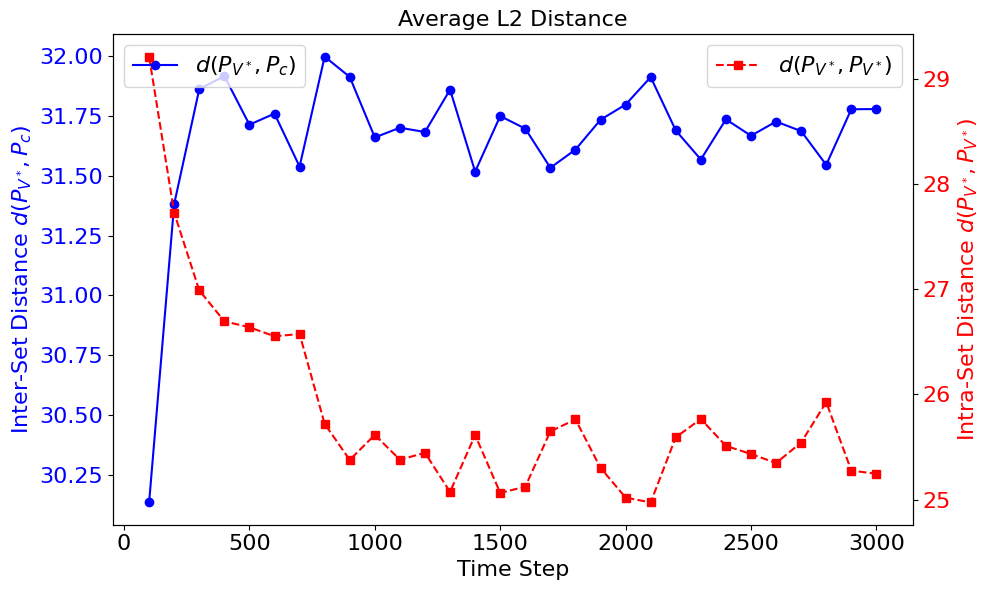

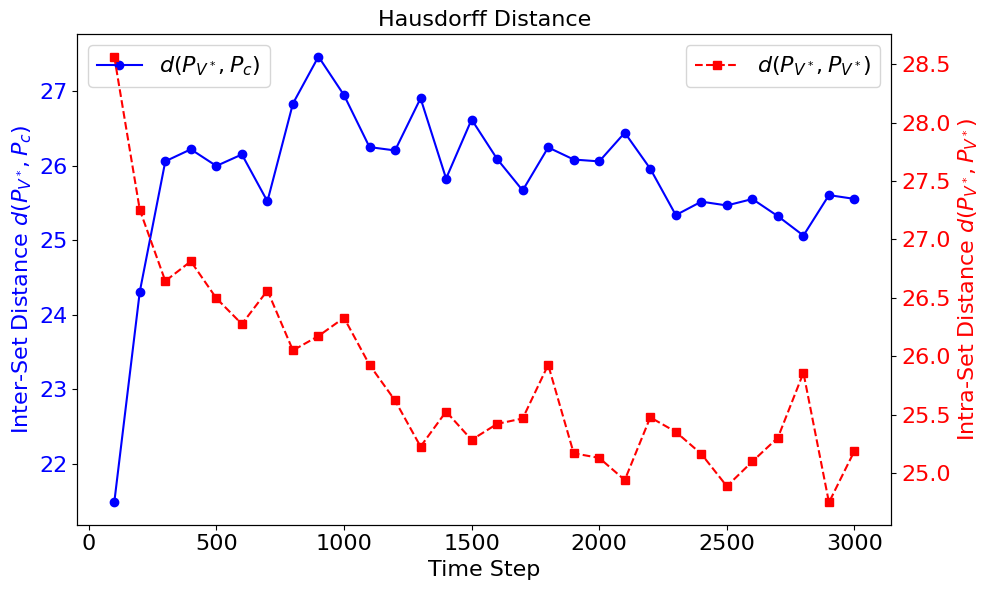

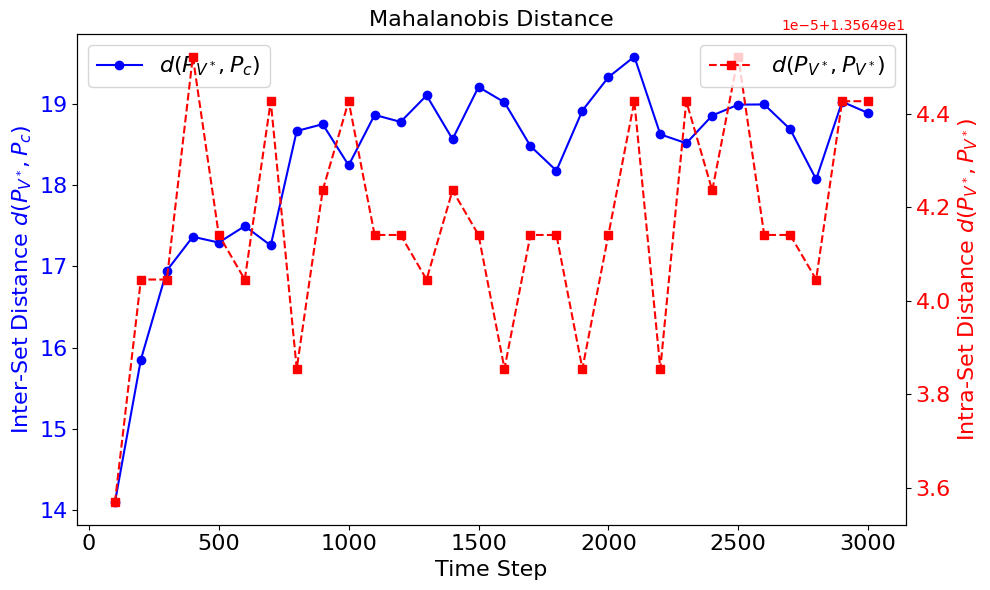

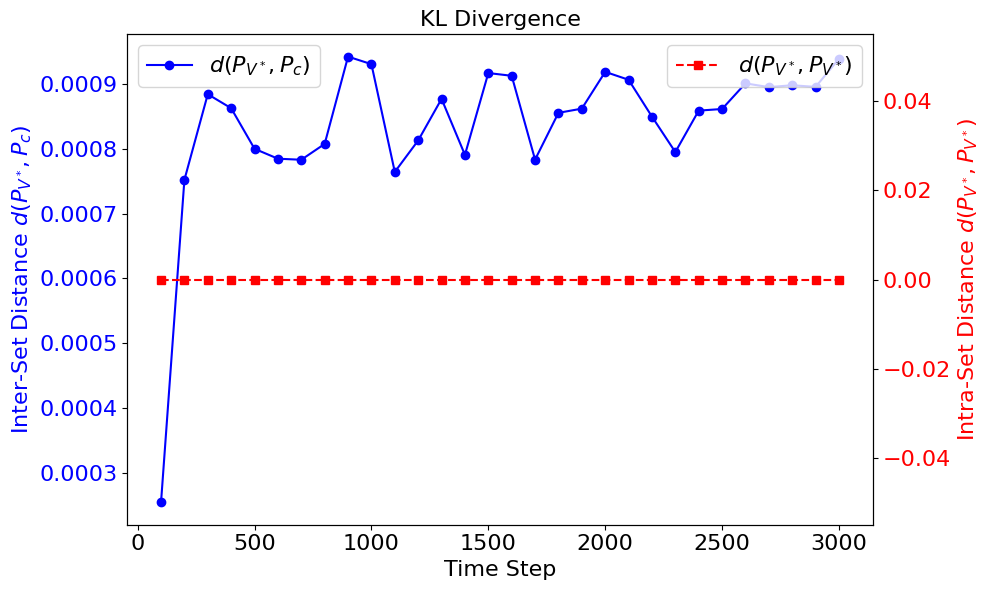

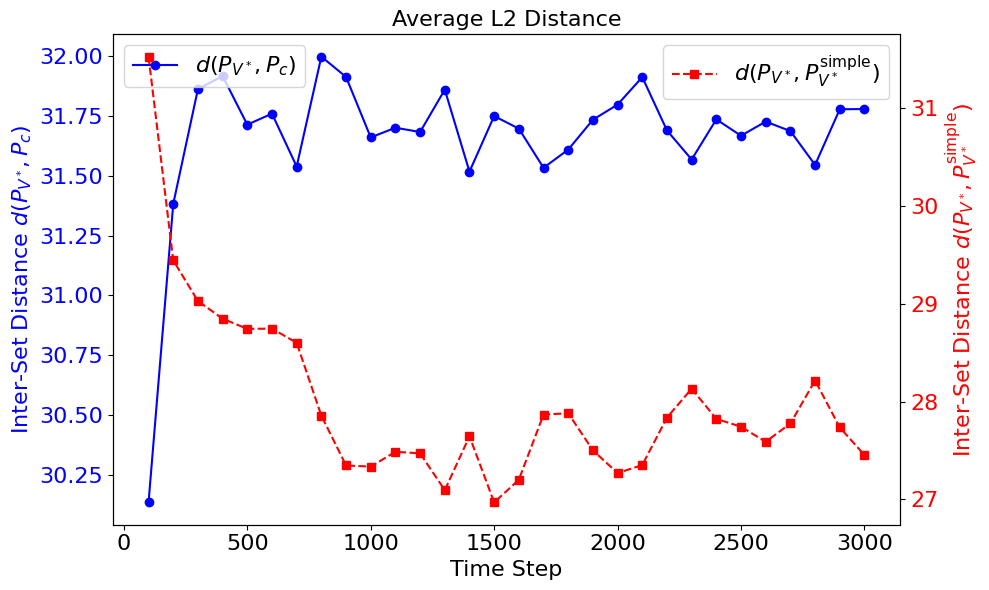

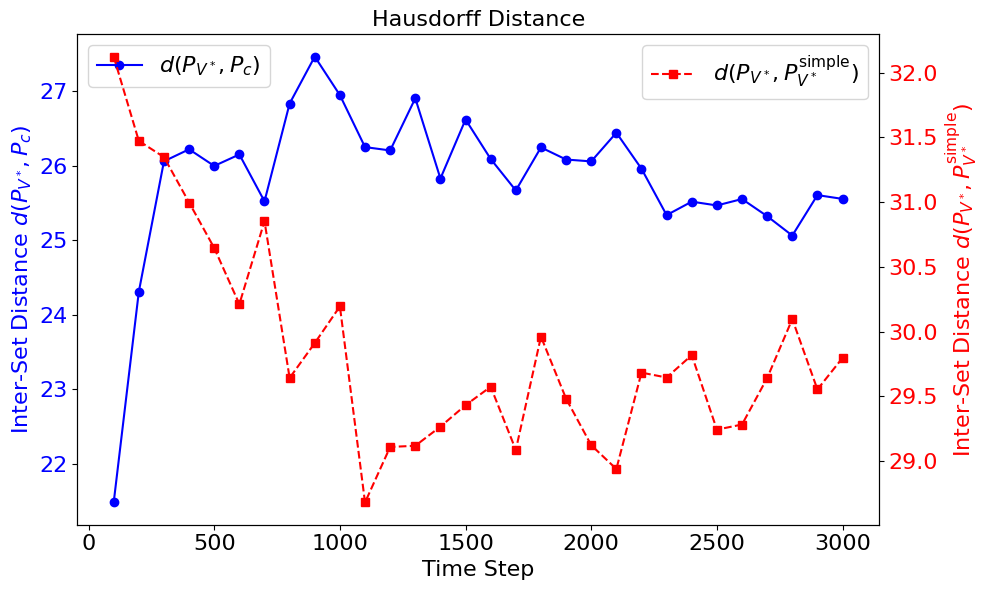

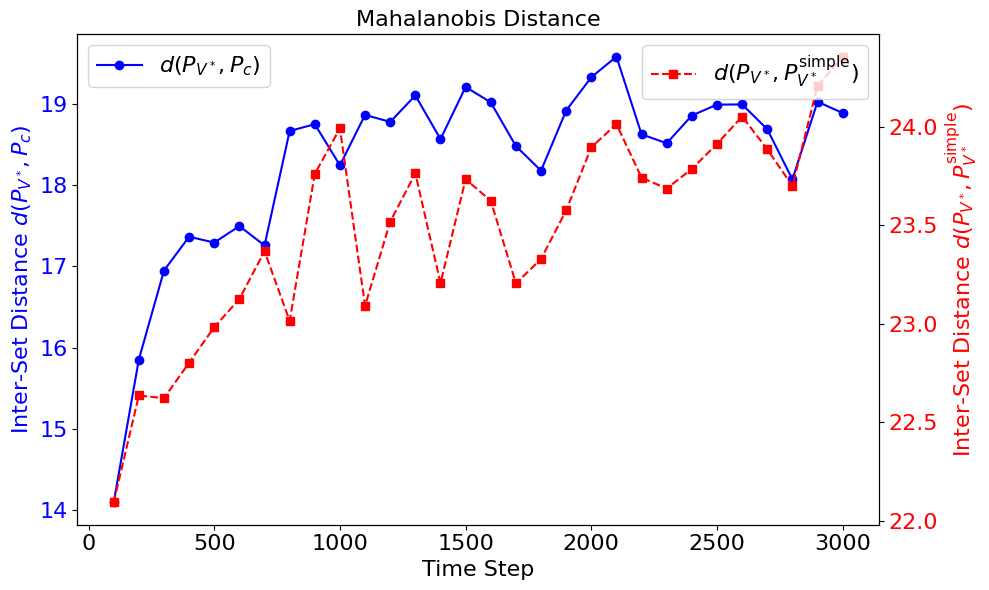

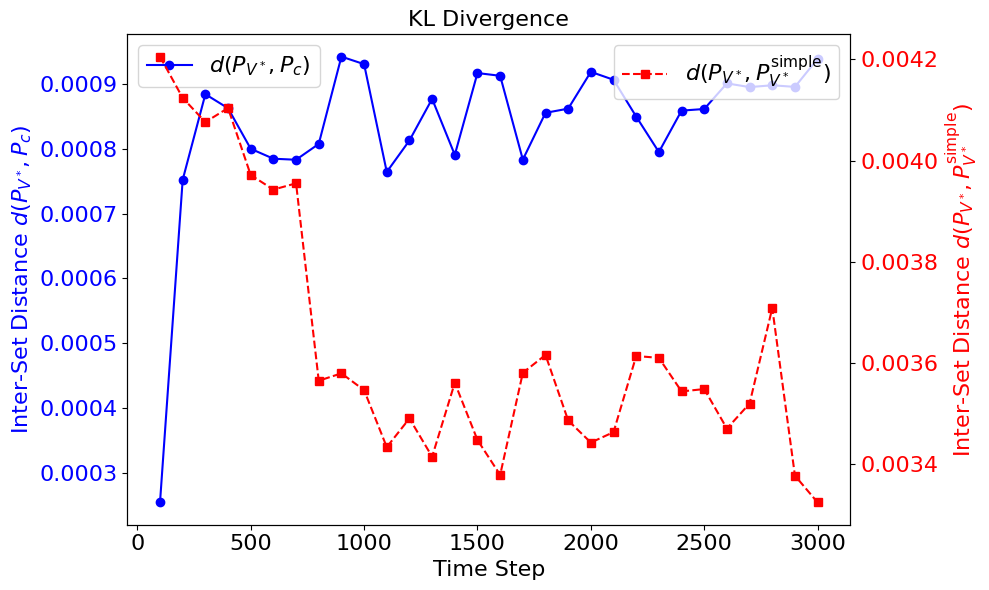

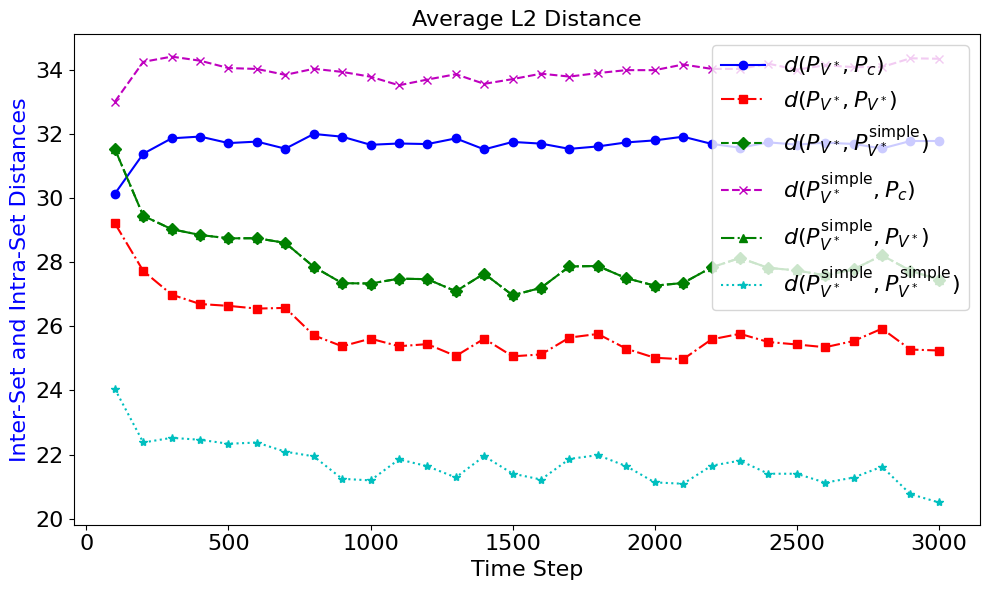

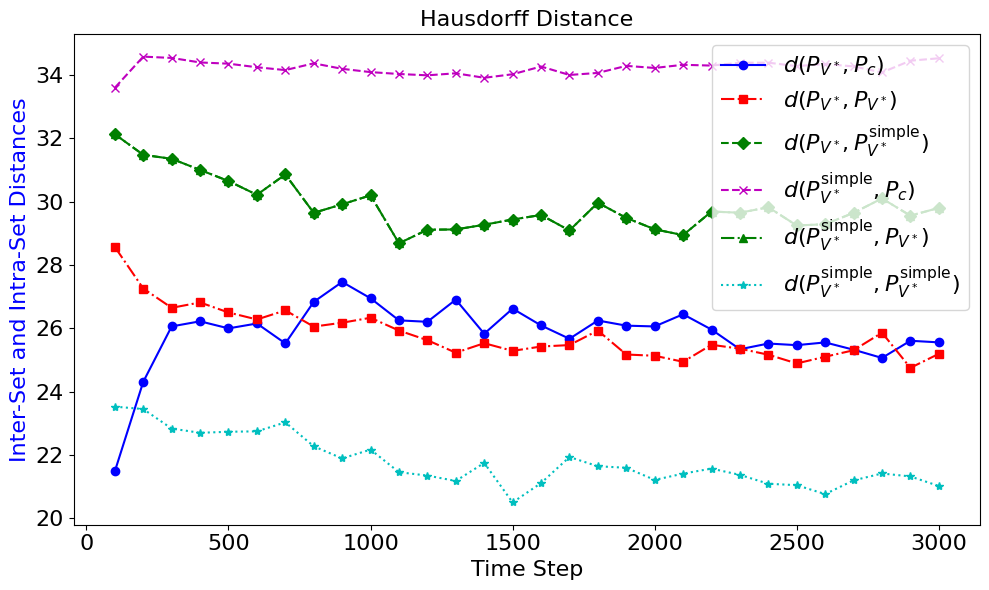

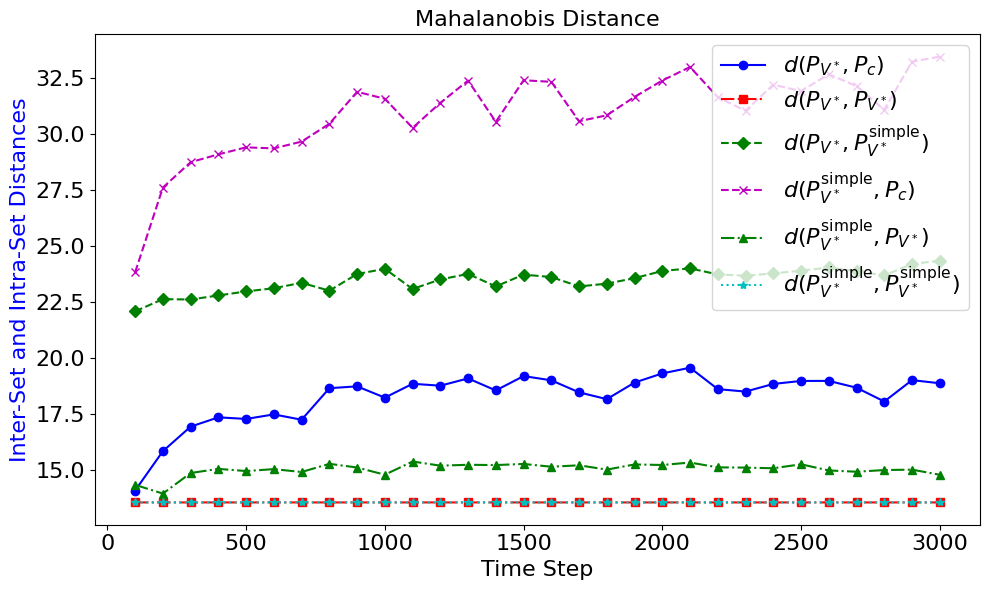

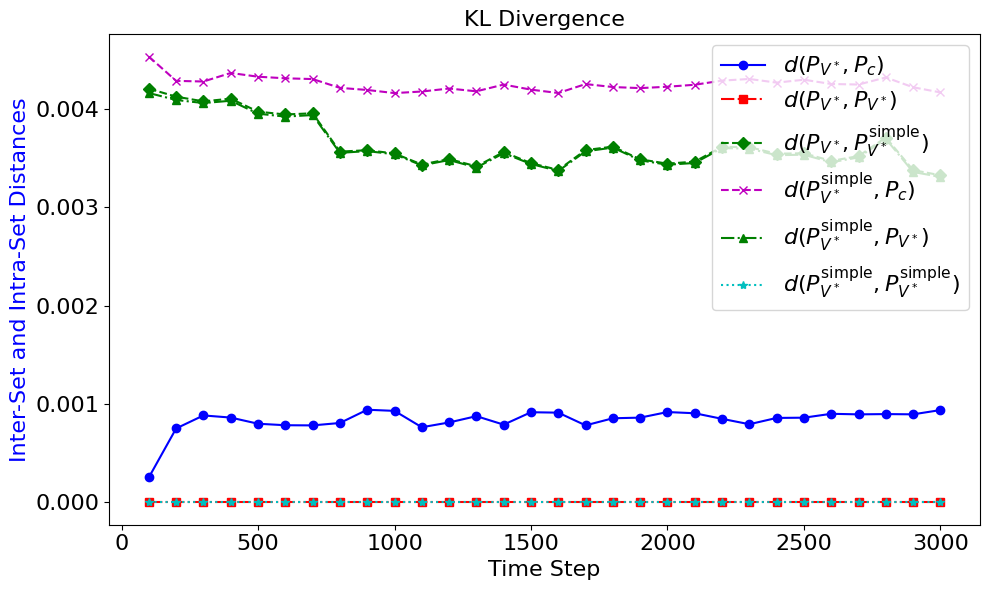

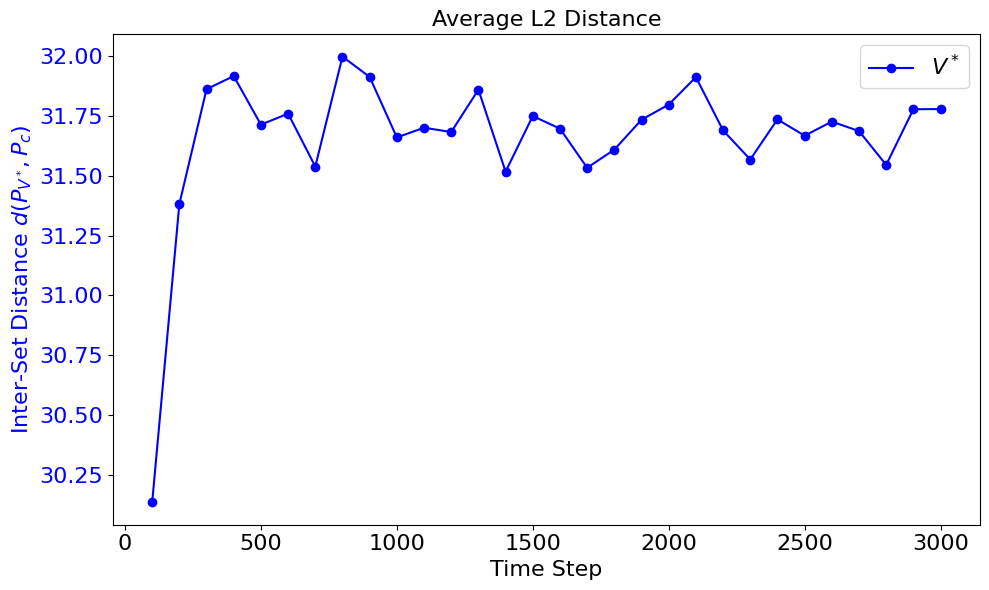

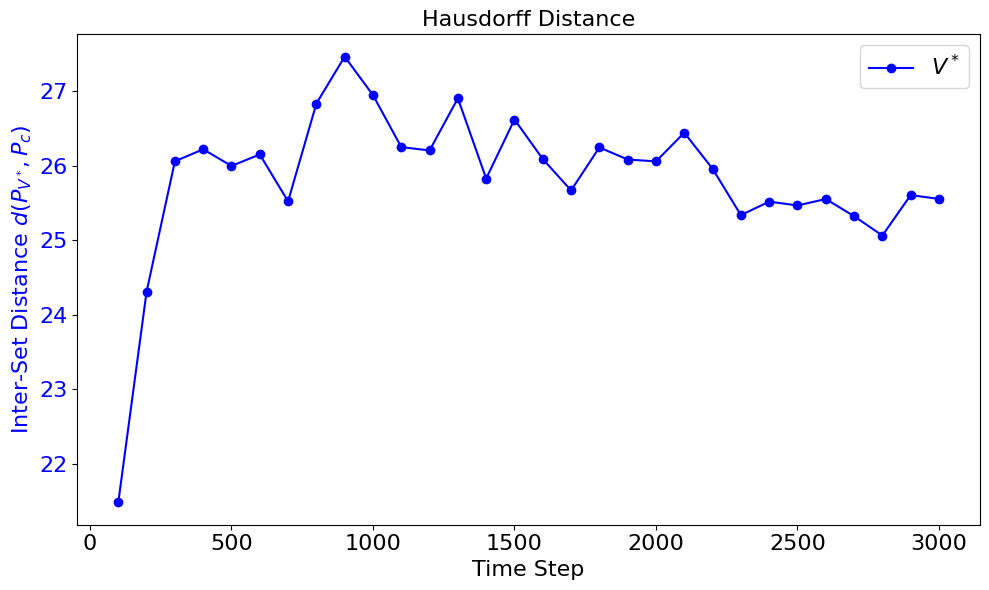

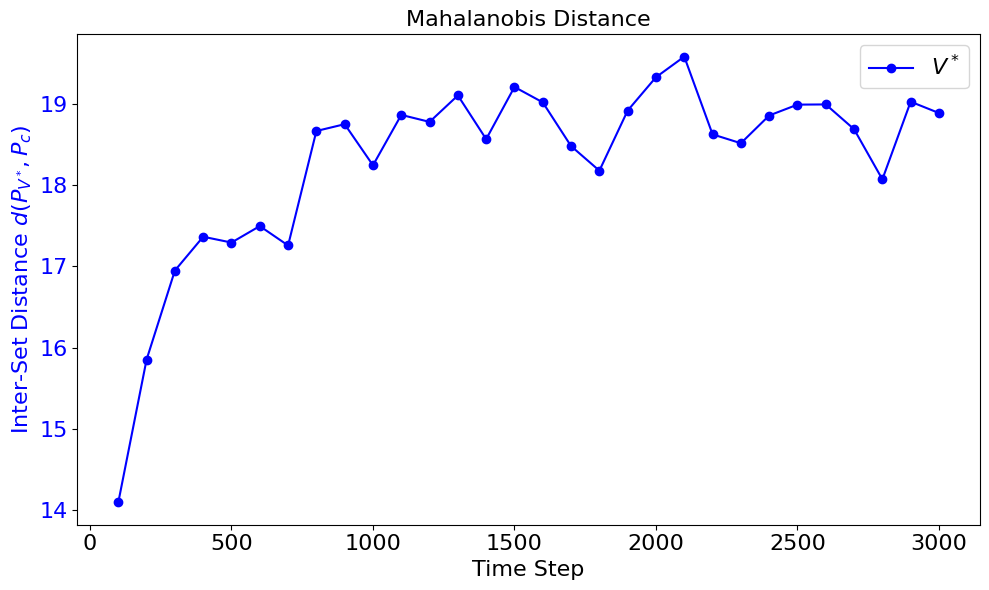

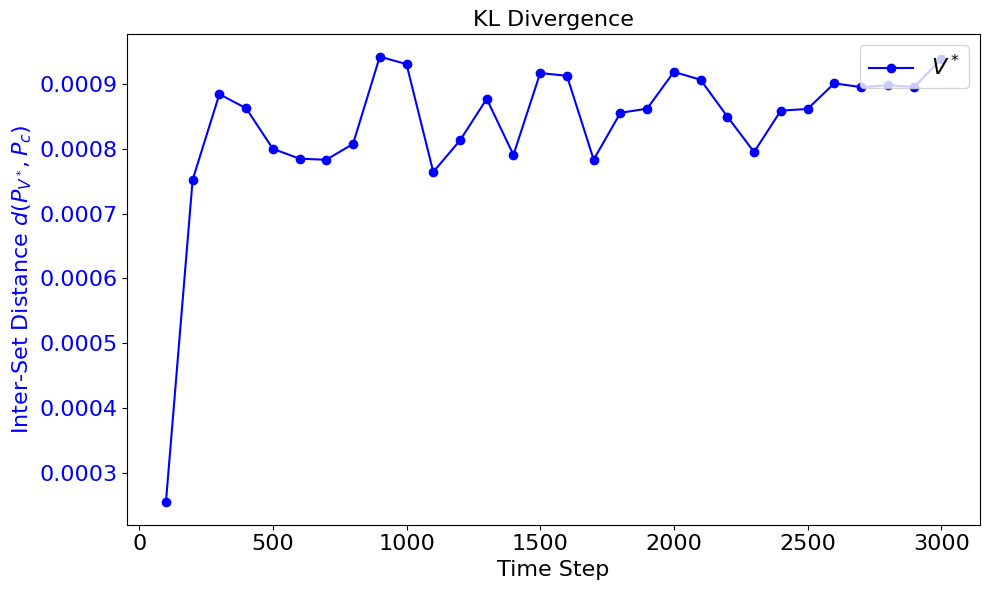

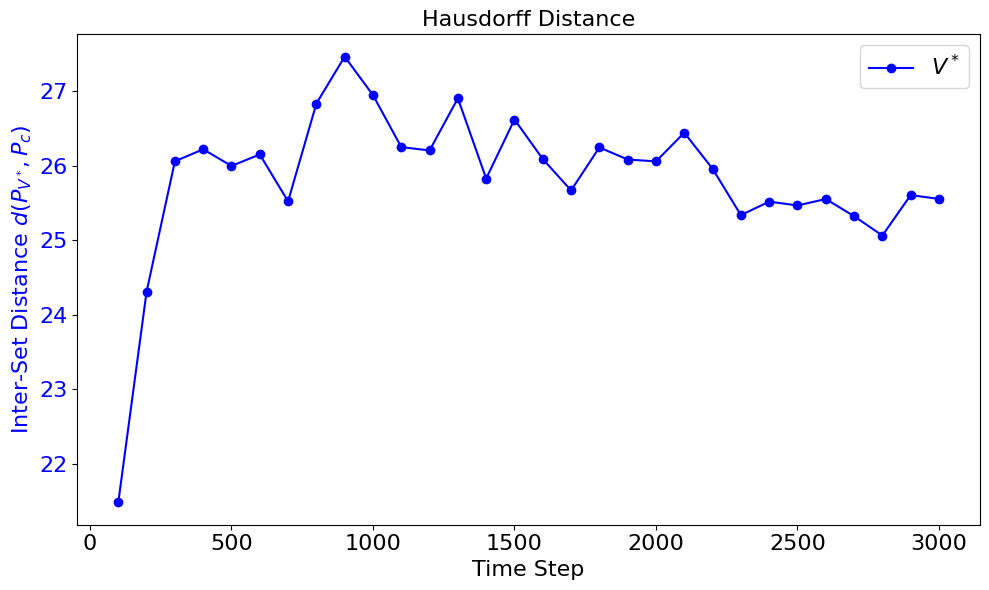

In [ ]:
label_dict = {
    'dist_average': 'Average L2 Distance',
    'dist_minimum_distance': 'Minimum L2 Distance',
    'dist_maximum_similarity': 'Maximum Cosine Similarity',
    'dist_hausdorff': 'Hausdorff Distance',
    'dist_infoNCE': 'InfoNCE Distance',
    'dist_mahalanobis': 'Mahalanobis Distance',
    'kl_divergence': 'KL Divergence',
    'dist_hausdorff_intra': 'Intra-Hausdorff Distance'
}

subjects_to_plot = ['banana', 'toy', 'bus']

colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k']
markers = ['o', 's', 'D', 'P', 'X', 'v', 'h']
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

font_size = 16  # Increased from 12
line_width = 2

os.makedirs(save_path, exist_ok=True)

set_distances = ['dist_average', 'dist_hausdorff', 'dist_mahalanobis', 'kl_divergence']

def change_label(label):
    if label == r'$d(P, P)$':
        return r'$d(P_{V^*}, P_{V^*})$'
    elif label == r'$d(P, Q)$':
        return r'$d(P_{V^*}, P_{c})$'
    elif label == r'$d(P, S)$':
        return r'$d(P_{V^*}, P_{V^*}^{\text{simple}})$'
    elif label == r'$d(S, Q)$':
        return r'$d(P_{V^*}^{\text{simple}}, P_{c})$'
    elif label == r'$d(S, S)$':
        return r'$d(P_{V^*}^{\text{simple}}, P_{V^*}^{\text{simple}})$'
    elif label == r'$d(S, P)$':
        return r'$d(P_{V^*}^{\text{simple}}, P_{V^*})$'
    else:
        return label

for dist_func in set_distances:
    print('dist_func', dist_func)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot P_vs_P on the first y-axis
    cur_self = []
    print(P_vs_P[dist_func])
    for time_step in P_vs_P[dist_func]:
        cur_self.append(torch.mean(P_vs_P[dist_func][time_step]).item())
    ax2.plot(P_vs_P[dist_func].keys(), cur_self, label=change_label(r'$d(P, P)$'), color='r', marker='s', linestyle='--')
    ax2.set_ylabel('Intra-Set Distance ' + change_label(r'$d(P, P)$'), color='r', fontsize=font_size)
    ax2.tick_params(axis='y', labelcolor='r', labelsize=font_size)


    # Plot P_vs_Q on the second y-axis
    cur_ref = []
    print(P_vs_Q[dist_func])
    for time_step in P_vs_Q[dist_func]:
        cur_ref.append(torch.mean(P_vs_Q[dist_func][time_step]).item())
    ax1.plot(P_vs_Q[dist_func].keys(), cur_ref, label=change_label(r'$d(P, Q)$'), color='b', marker='o', linestyle='-')
    ax1.set_ylabel('Inter-Set Distance ' + change_label(r'$d(P, Q)$'), color='b', fontsize=font_size)
    ax1.tick_params(axis='y', labelcolor='b', labelsize=font_size)

    # Set common x-axis label and title
    ax1.set_xlabel('Time Step', fontsize=font_size)
    ax1.tick_params(axis='x', labelsize=font_size)
    plt.title(f'{label_dict[dist_func]}', fontsize=font_size)

    # Add legends
    ax1.legend(loc='upper left', fontsize=font_size)
    ax2.legend(loc='upper right', fontsize=font_size)

    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(save_path, f'{dist_func}.png'))

for dist_func in set_distances:
    print('dist_func', dist_func)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Create a second y-axis
    ax2 = ax1.twinx()

    # Plot res on the first y-axis
    cur_self = []
    print(P_vs_S[dist_func])
    for time_step in P_vs_S[dist_func]:
        cur_self.append(torch.mean(P_vs_S[dist_func][time_step]).item())
    ax2.plot(P_vs_S[dist_func].keys(), cur_self, label=change_label(r'$d(P, S)$'), color='r', marker='s', linestyle='--')
    ax2.set_ylabel('Inter-Set Distance ' + change_label(r'$d(P, S)$'), color='r', fontsize=font_size)
    ax2.tick_params(axis='y', labelcolor='r', labelsize=font_size)


    # Plot P_vs_Q on the second y-axis
    cur_ref = []
    print(P_vs_Q[dist_func])
    for time_step in P_vs_Q[dist_func]:
        cur_ref.append(torch.mean(P_vs_Q[dist_func][time_step]).item())
    ax1.plot(P_vs_Q[dist_func].keys(), cur_ref, label=change_label(r'$d(P, Q)$'), color='b', marker='o', linestyle='-')
    ax1.set_ylabel('Inter-Set Distance ' + change_label(r'$d(P, Q)$'), color='b', fontsize=font_size)
    ax1.tick_params(axis='y', labelcolor='b', labelsize=font_size)

    # Set common x-axis label and title
    ax1.set_xlabel('Time Step', fontsize=font_size)
    ax1.tick_params(axis='x', labelsize=font_size)
    plt.title(f'{label_dict[dist_func]}', fontsize=font_size)

    # Add legends
    ax1.legend(loc='upper left', fontsize=font_size)
    ax2.legend(loc='upper right', fontsize=font_size)

    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(save_path, f'simple_inter_set_{dist_func}.png'))


for dist_func in set_distances:
    print('dist_func', dist_func)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot P_vs_Q
    cur_ref = []
    print(P_vs_Q[dist_func])
    for time_step in P_vs_Q[dist_func]:
        cur_ref.append(torch.mean(P_vs_Q[dist_func][time_step]).item())
    ax1.plot(P_vs_Q[dist_func].keys(), cur_ref, label=change_label(r'$d(P, Q)$'), color='b', marker='o', linestyle='-')

    # Plot P_vs_P on the first y-axis
    cur_self = []
    print(P_vs_P[dist_func])
    for time_step in P_vs_P[dist_func]:
        cur_self.append(torch.mean(P_vs_P[dist_func][time_step]).item())
    ax1.plot(P_vs_P[dist_func].keys(), cur_self, label=change_label(r'$d(P, P)$'), color='r', marker='s', linestyle='-.')

    # Plot P_vs_S on the first y-axis
    cur_self = []
    print(P_vs_S[dist_func])
    for time_step in P_vs_S[dist_func]:
        cur_self.append(torch.mean(P_vs_S[dist_func][time_step]).item())
    ax1.plot(P_vs_S[dist_func].keys(), cur_self, label=change_label(r'$d(P, S)$'), color='k', marker='D', linestyle='--')


    # Plot S_vs_Q on the first y-axis
    cur_ref = []
    print(S_vs_Q[dist_func])
    for time_step in S_vs_Q[dist_func]:
        cur_ref.append(torch.mean(S_vs_Q[dist_func][time_step]).item())
    ax1.plot(S_vs_Q[dist_func].keys(), cur_ref, label=change_label(r'$d(S, Q)$'), color='m', marker='x', linestyle='--')

    # Plot S_vs_P on the first y-axis
    cur_self = []
    print(S_vs_P[dist_func])
    for time_step in S_vs_P[dist_func]:
        cur_self.append(torch.mean(S_vs_P[dist_func][time_step]).item())
    ax1.plot(S_vs_P[dist_func].keys(), cur_self, label=change_label(r'$d(S, P)$'), color='g', marker='^', linestyle='-.')

    # Plot S_vs_S on the first y-axis
    cur_self = []
    print(S_vs_S[dist_func])
    for time_step in S_vs_S[dist_func]:
        cur_self.append(torch.mean(S_vs_S[dist_func][time_step]).item())
    ax1.plot(S_vs_S[dist_func].keys(), cur_self, label=change_label(r'$d(S, S)$'), color='c', marker='*', linestyle=':')


    ax1.set_ylabel('Inter-Set and Intra-Set Distances', color='b', fontsize=font_size)
    ax1.tick_params(axis='y', labelsize=font_size)

    # Set common x-axis label and title
    ax1.set_xlabel('Time Step', fontsize=font_size)
    ax1.tick_params(axis='x', labelsize=font_size)
    plt.title(f'{label_dict[dist_func]}', fontsize=font_size)

    # Add legends
    ax1.legend(loc='upper right', fontsize=font_size)

    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(save_path, f'all_distances_{dist_func}.png'))

for dist_func in set_distances:
    print('dist_func', dist_func)
    fig, ax1 = plt.subplots(figsize=(10, 6))

    # Plot res on the first y-axis
    for isub, subject in enumerate(all_subjects_reference.keys()):
        cur_self = []
        print(all_subjects_reference[subject][dist_func])
        for time_step in all_subjects_reference[subject][dist_func]:
            cur_self.append(torch.mean(all_subjects_reference[subject][dist_func][time_step]).item())
        ax1.plot(all_subjects_reference[subject][dist_func].keys(), cur_self, label=f'{subject}', color=colors[isub], marker=markers[isub], linestyle=line_styles[isub])
    
    ax1.set_ylabel('Inter-Set Distance ' + change_label(r'$d(P, Q)$'), color='b', fontsize=font_size)
    ax1.tick_params(axis='y', labelcolor='b', labelsize=font_size)

    # Set common x-axis label and title
    ax1.set_xlabel('Time Step', fontsize=font_size)
    ax1.tick_params(axis='x', labelsize=font_size)
    plt.title(f'{label_dict[dist_func]}', fontsize=font_size)

    # Add legends
    ax1.legend(loc='upper right', fontsize=font_size)

    plt.tight_layout()
    # plt.show()
    plt.savefig(os.path.join(save_path, f'inter_set_distance_{dist_func}.png'))

dist_func = 'dist_hausdorff'
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot res on the first y-axis
for isub, subject in enumerate(all_subjects_reference.keys()):
    if subject == 'man':
        continue
    cur_self = []
    print(all_subjects_reference[subject][dist_func])
    for time_step in all_subjects_reference[subject][dist_func]:
        cur_self.append(torch.mean(all_subjects_reference[subject][dist_func][time_step]).item())
    ax1.plot(all_subjects_reference[subject][dist_func].keys(), cur_self, label=f'{subject}', color=colors[isub], marker=markers[isub], linestyle=line_styles[isub])

ax1.set_ylabel('Inter-Set Distance ' + change_label(r'$d(P, Q)$'), color='b', fontsize=font_size)
ax1.tick_params(axis='y', labelcolor='b', labelsize=font_size)

# Set common x-axis label and title
ax1.set_xlabel('Time Step', fontsize=font_size)
ax1.tick_params(axis='x', labelsize=font_size)
plt.title(f'{label_dict[dist_func]}', fontsize=font_size)

# Add legends
ax1.legend(loc='upper right', fontsize=font_size)

plt.tight_layout()
# plt.show()
plt.savefig(os.path.join(save_path, f'inter_set_distance_{dist_func}.png'))



dist_func dist_average_all
{100: tensor([22.9447, 23.7851, 23.3895, 24.0351, 23.2530, 23.3460, 22.9922, 22.7513,
        25.2974, 24.4027, 24.1602, 25.0033, 24.2393, 25.4950, 27.1147, 24.0948,
        25.0717], device='cuda:0'), 200: tensor([23.5672, 24.2570, 23.8237, 24.4012, 23.1620, 23.3879, 22.9903, 22.8627,
        25.2107, 24.6988, 24.2959, 24.9375, 24.4960, 25.7553, 27.1590, 24.7327,
        24.9595], device='cuda:0'), 300: tensor([22.7508, 23.5252, 23.0162, 23.4891, 22.6548, 23.1173, 22.7933, 22.6746,
        25.0234, 24.4265, 24.1718, 24.7340, 24.0119, 25.4386, 26.7220, 24.3541,
        24.7509], device='cuda:0'), 400: tensor([22.7087, 23.4075, 22.9779, 23.4046, 22.4616, 23.0238, 22.9427, 22.6509,
        25.1749, 24.4949, 24.2471, 24.6414, 24.1145, 25.1273, 26.5343, 24.2828,
        24.5827], device='cuda:0'), 500: tensor([22.5978, 23.2618, 22.8976, 23.2907, 22.3265, 22.8627, 22.9822, 22.6485,
        25.1528, 24.5225, 24.2461, 24.5284, 23.9319, 25.0488, 26.6424, 24.1703,
   

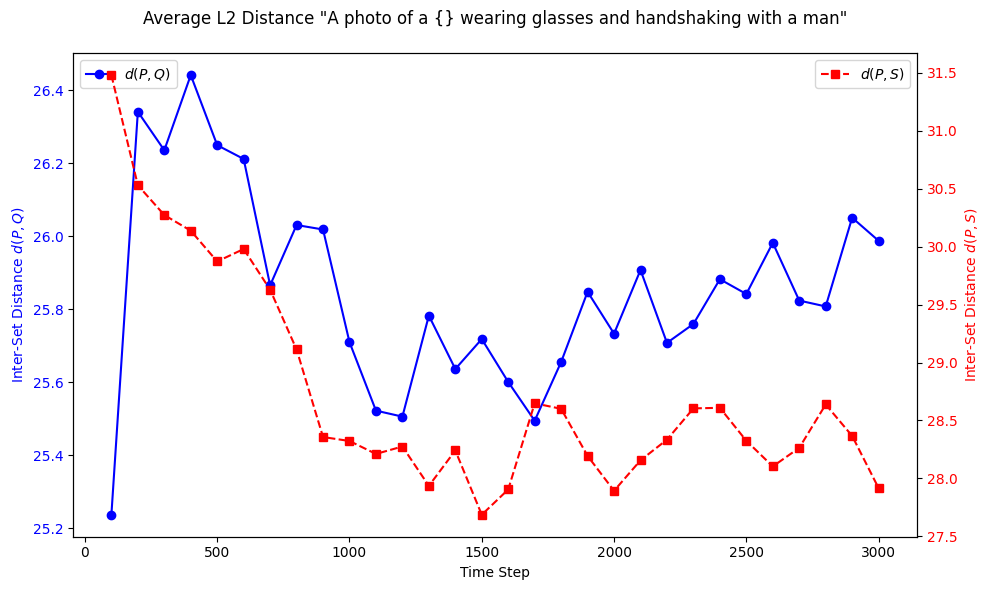

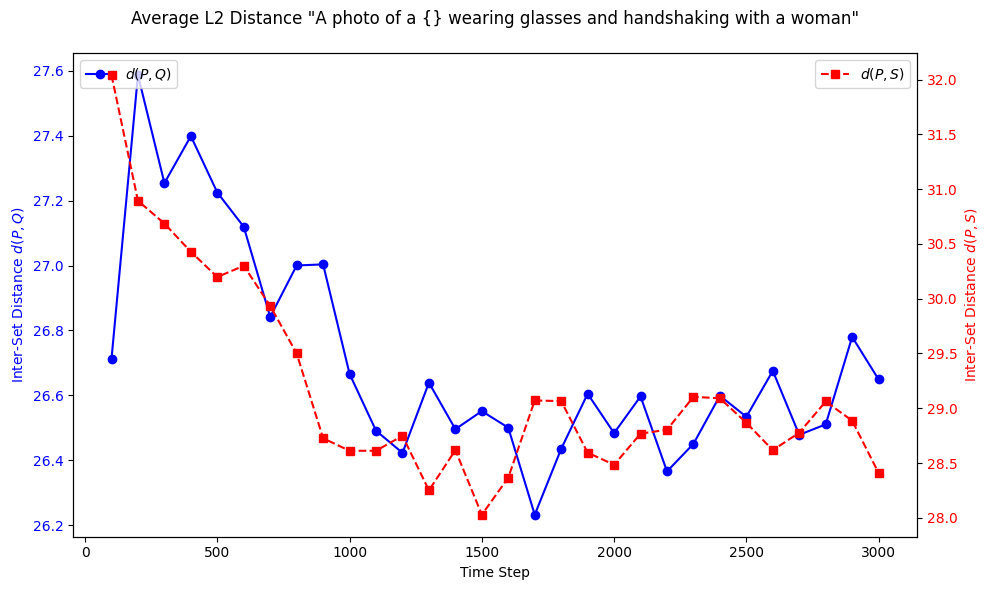

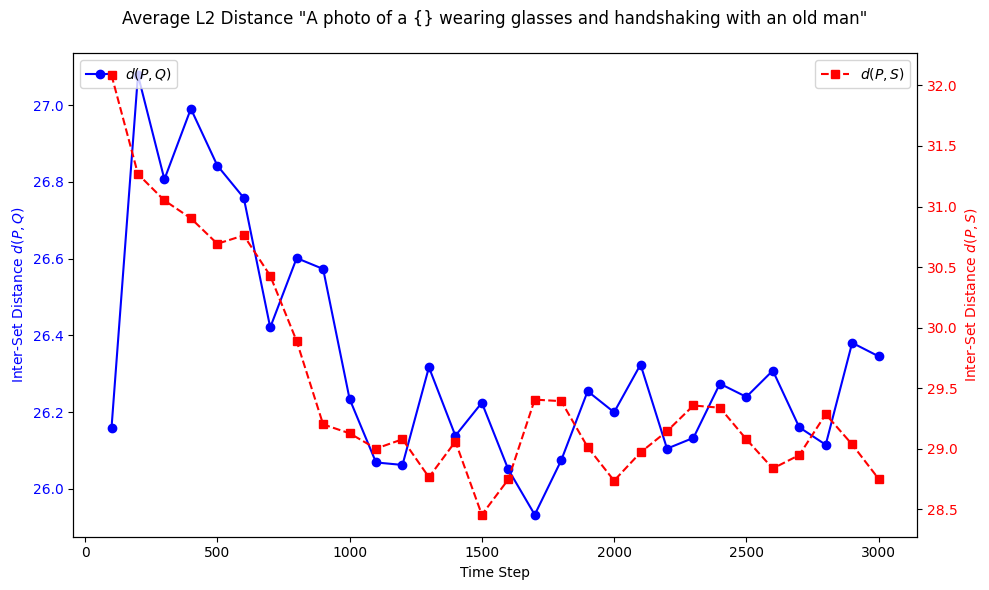

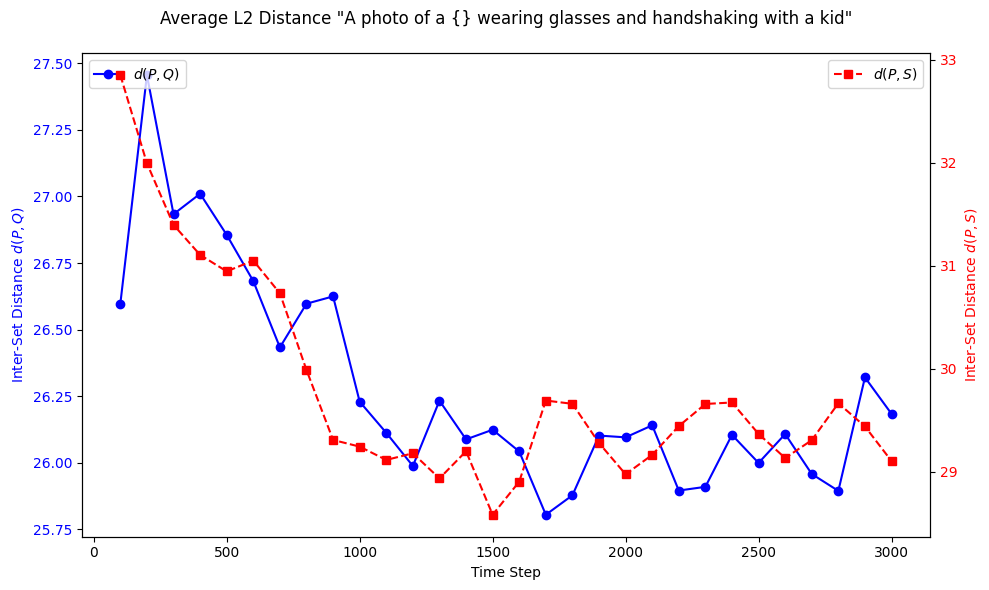

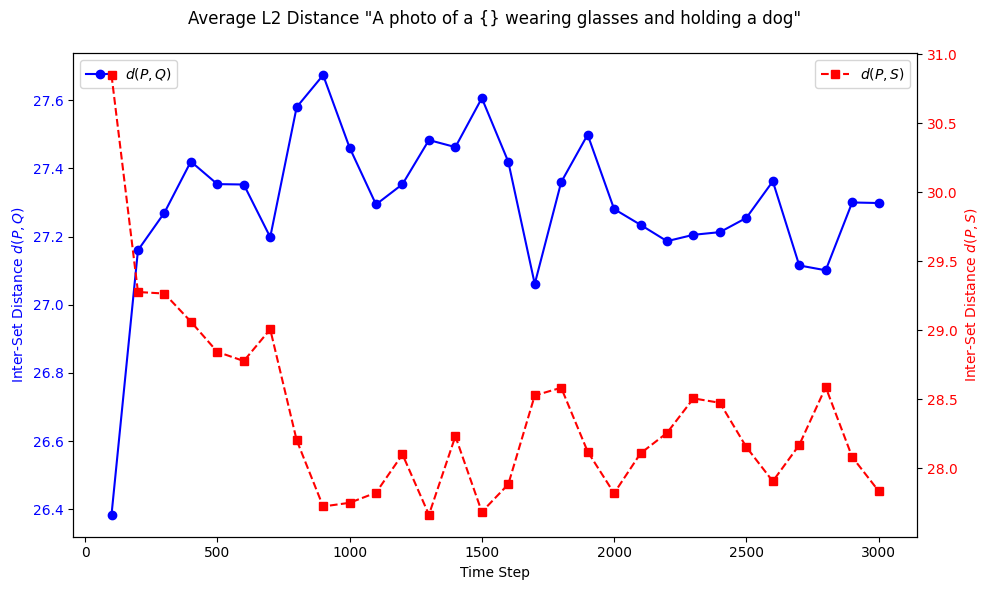

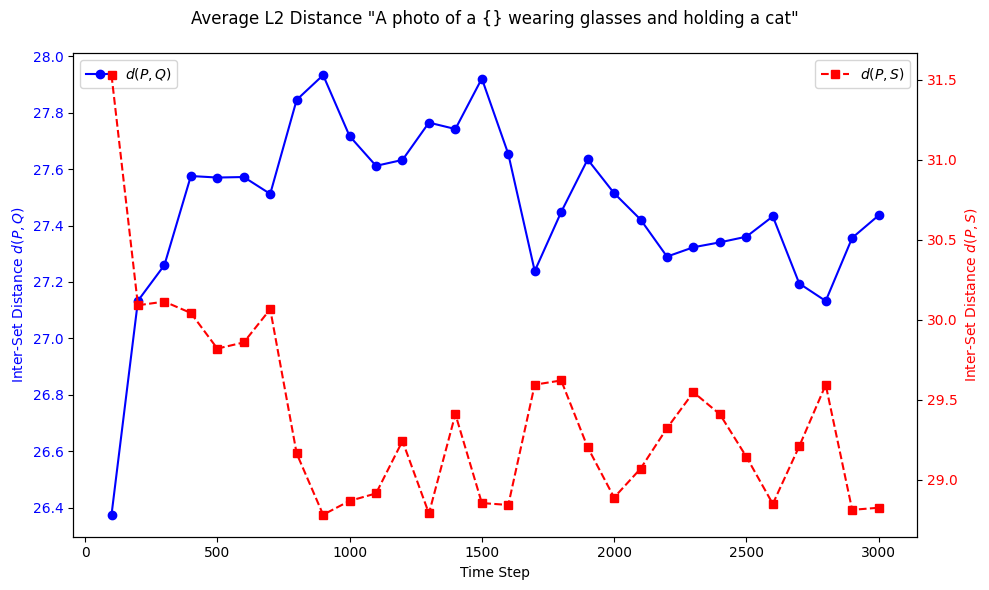

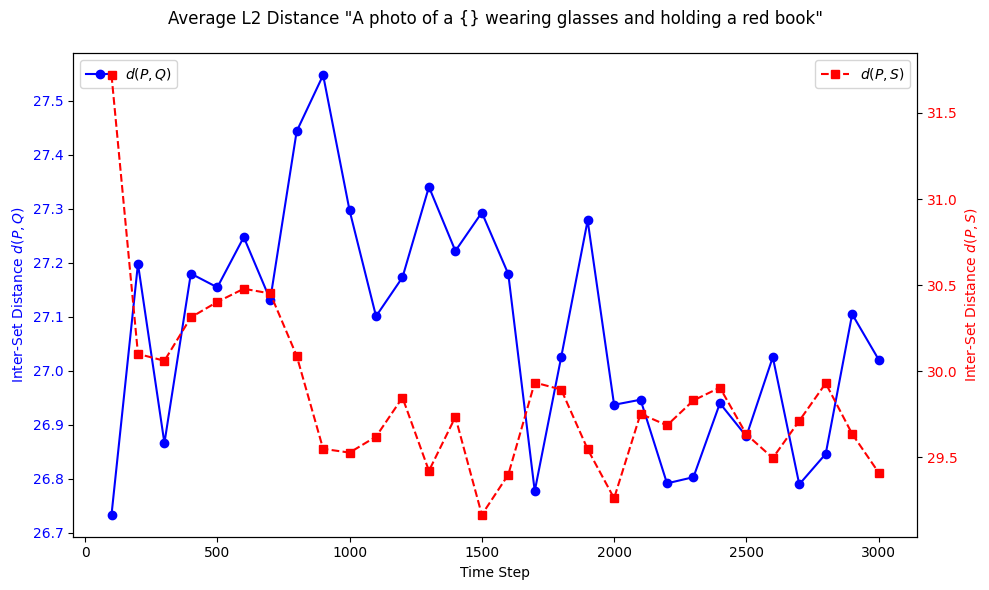

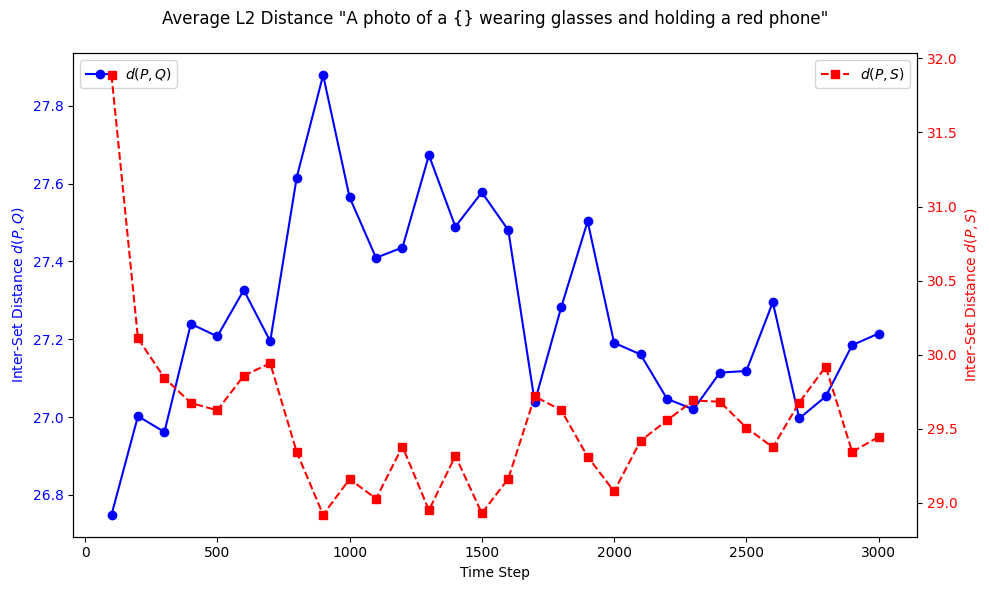

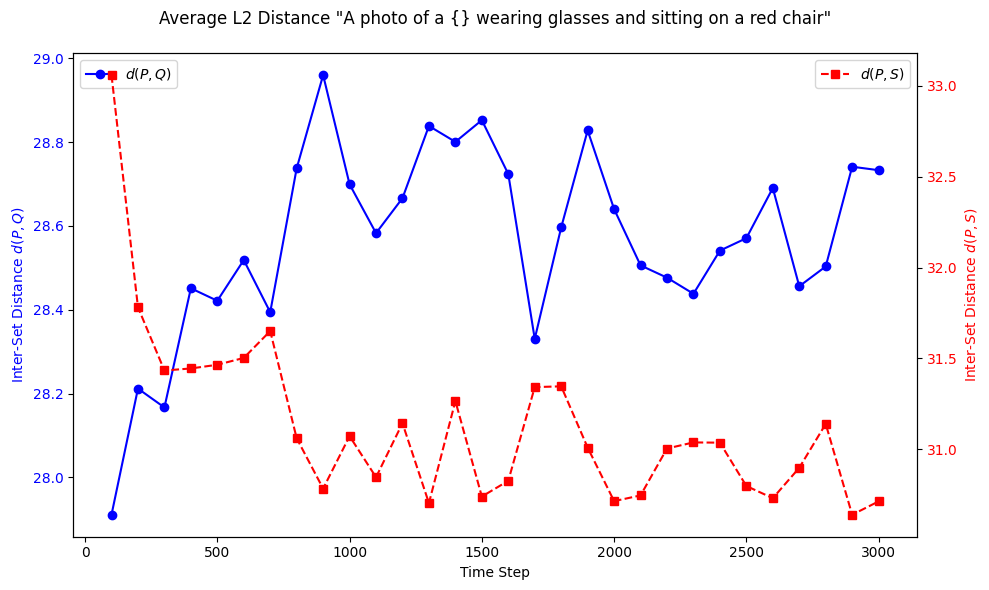

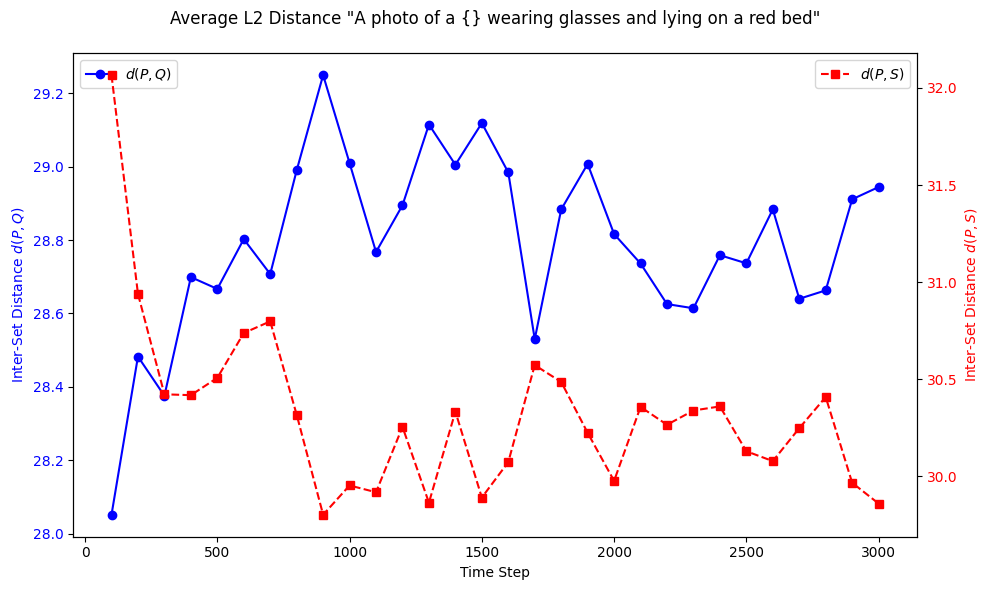

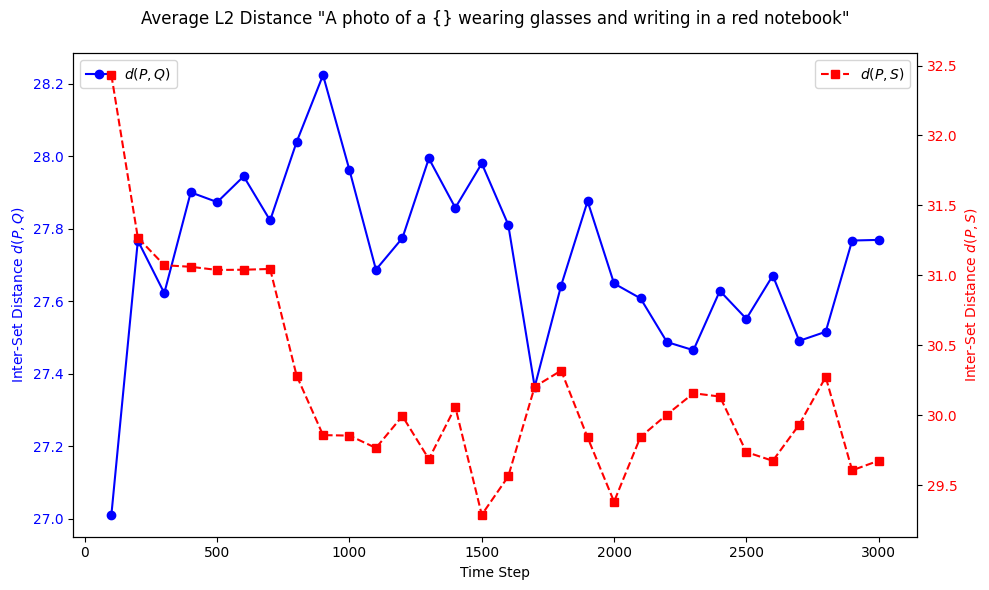

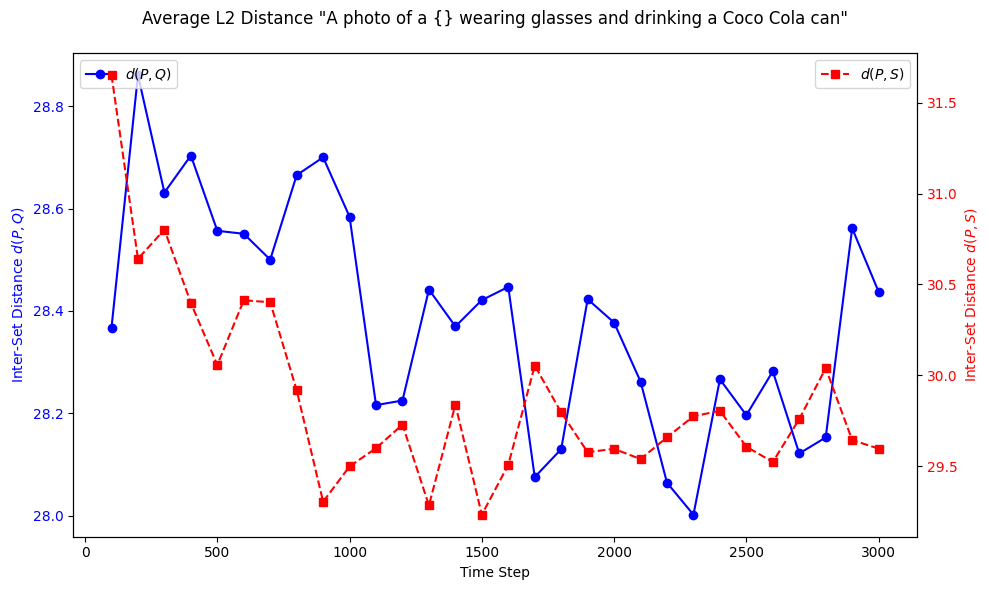

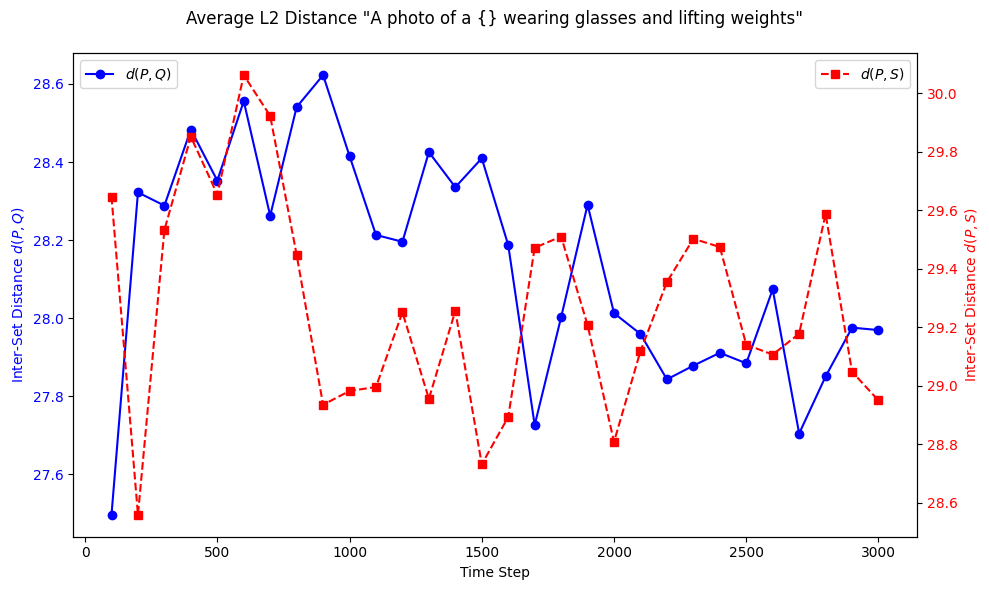

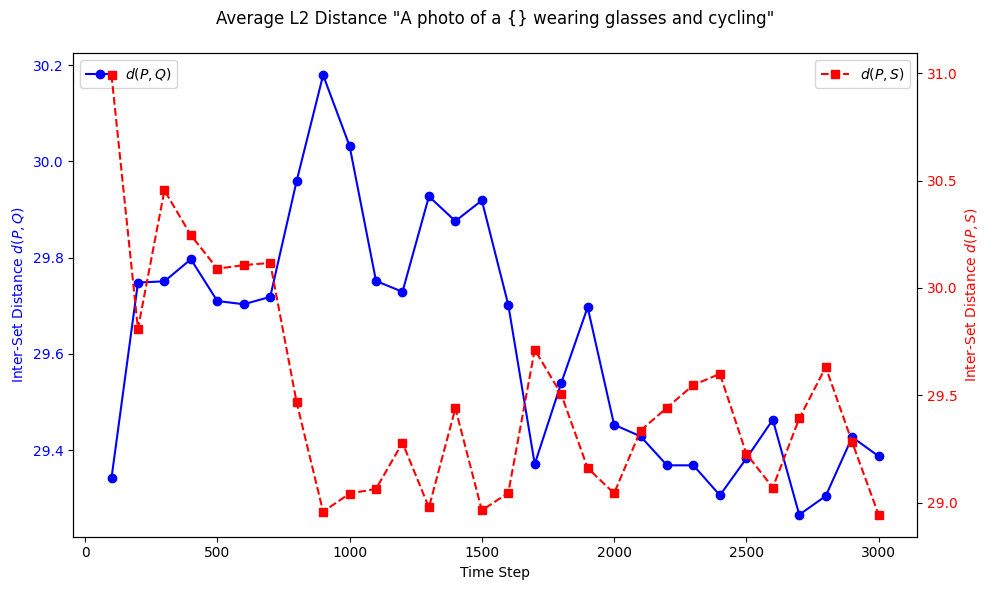

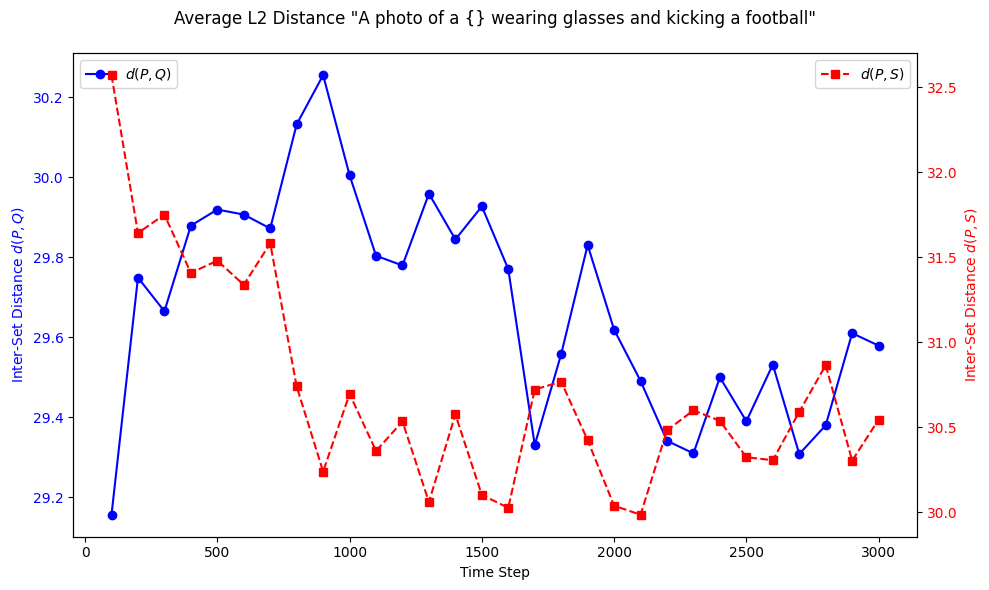

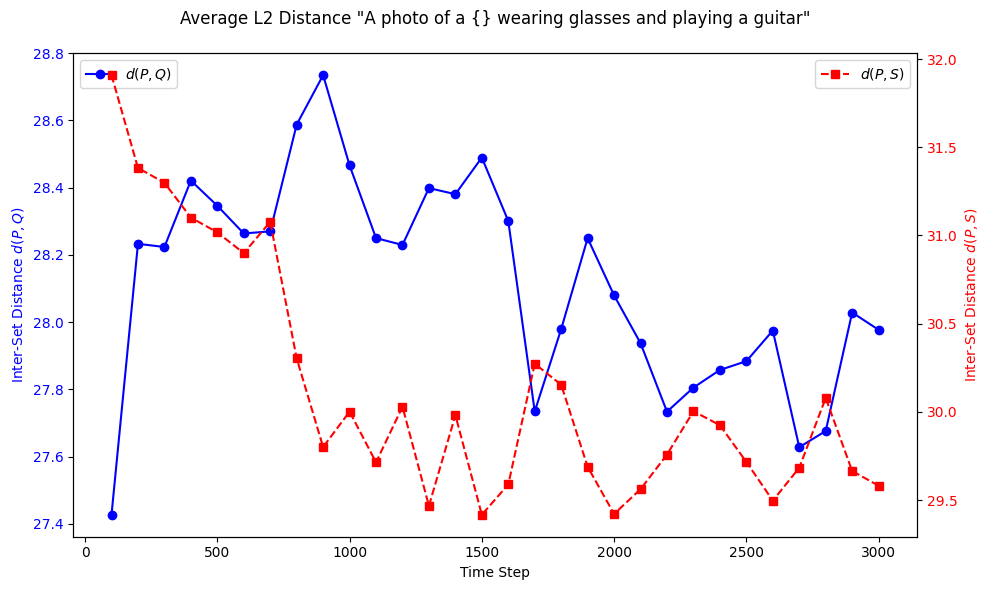

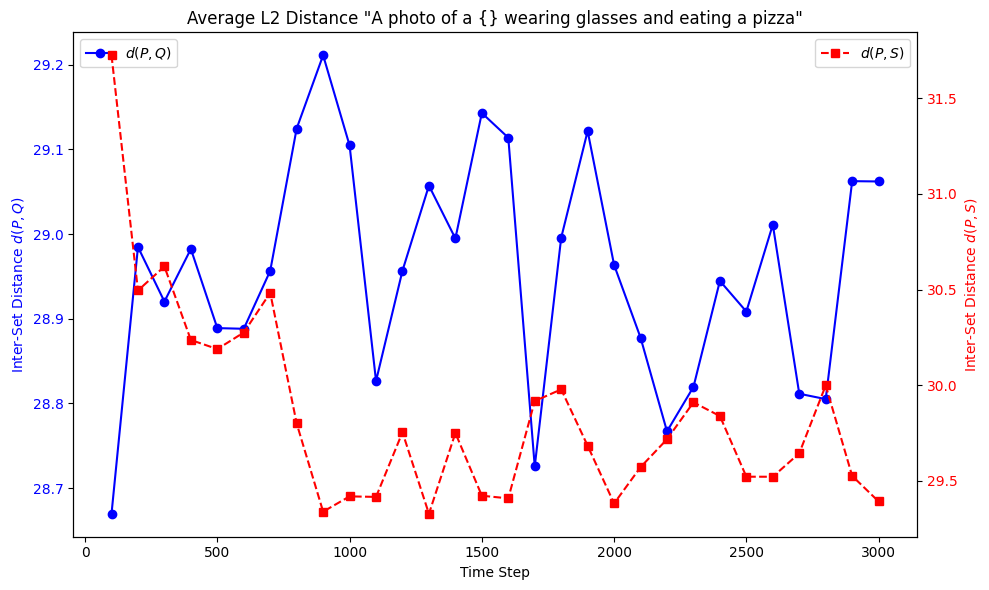

In [53]:
label_dict = {
    'dist_average': 'Average L2 Distance',
    'dist_minimum_distance': 'Minimum L2 Distance',
    'dist_maximum_similarity': 'Maximum Cosine Similarity',
    'dist_hausdorff': 'Hausdorff Distance',
    'dist_infoNCE': 'InfoNCE Distance',
    'dist_mahalanobis': 'Mahalanobis Distance',
    'kl_divergence': 'KL Divergence',
    'dist_hausdorff_intra': 'Intra-Hausdorff Distance',
    'dist_average_all': 'Average L2 Distance'
}

subjects_to_plot = ['banana', 'toy', 'bus']

colors = ['b', 'r', 'g', 'y', 'm', 'c', 'k']
markers = ['o', 's', 'D', 'P', 'X', 'v', 'h']
line_styles = ['-', '--', '-.', ':', '-', '--', '-.', ':']

os.makedirs(save_path, exist_ok=True)

set_distances = ['dist_average_all']


for dist_func in set_distances:
    for prompt_index in range(len(P_vs_P['dist_average_all'][100])):
        print('dist_func', dist_func)
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Create a second y-axis
        ax2 = ax1.twinx()

        # Plot P_vs_P on the first y-axis
        cur_self = []
        print(P_vs_P[dist_func])
        for time_step in P_vs_P[dist_func]:
            cur_self.append(P_vs_P[dist_func][time_step][prompt_index].item())
        ax2.plot(P_vs_P[dist_func].keys(), cur_self, label=r'$d(P, P)$', color='r', marker='s', linestyle='--')
        ax2.set_ylabel('Intra-Set Distance ' + r'$d(P, P)$', color='r')
        ax2.tick_params(axis='y', labelcolor='r')


        # Plot P_vs_Q on the second y-axis
        cur_ref = []
        print(P_vs_Q[dist_func])
        for time_step in P_vs_Q[dist_func]:
            cur_ref.append(P_vs_Q[dist_func][time_step][prompt_index].item())
        ax1.plot(P_vs_Q[dist_func].keys(), cur_ref, label=r'$d(P, Q)$', color='b', marker='o', linestyle='-')
        ax1.set_ylabel('Inter-Set Distance ' + r'$d(P, Q)$', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        # Set common x-axis label and title
        ax1.set_xlabel('Time Step')
        plt.title(f'{label_dict[dist_func]} {prompts_data[prompt_index]}')

        # Add legends
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.tight_layout()
        # plt.show()
        plt.savefig(os.path.join(save_path, f'{dist_func}_prompt_{prompt_index}.png'))
        plt.close()

for dist_func in set_distances:
    for prompt_index in range(len(P_vs_P['dist_average_all'][100])):
        print('dist_func', dist_func)
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Create a second y-axis
        ax2 = ax1.twinx()

        # Plot res on the first y-axis
        cur_self = []
        print(P_vs_S[dist_func])
        for time_step in P_vs_S[dist_func]:
            cur_self.append(P_vs_S[dist_func][time_step][prompt_index].item())
        ax2.plot(P_vs_S[dist_func].keys(), cur_self, label=r'$d(P, S)$', color='r', marker='s', linestyle='--')
        ax2.set_ylabel('Inter-Set Distance ' + r'$d(P, S)$', color='r')
        ax2.tick_params(axis='y', labelcolor='r')


        # Plot P_vs_Q on the second y-axis
        cur_ref = []
        print(P_vs_Q[dist_func])
        for time_step in P_vs_Q[dist_func]:
            cur_ref.append(P_vs_Q[dist_func][time_step][prompt_index].item())
        ax1.plot(P_vs_Q[dist_func].keys(), cur_ref, label=r'$d(P, Q)$', color='b', marker='o', linestyle='-')
        ax1.set_ylabel('Inter-Set Distance ' + r'$d(P, Q)$', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        # Set common x-axis label and title
        ax1.set_xlabel('Time Step')
        plt.title(f'{label_dict[dist_func]} {prompts_data[prompt_index]}')

        # Add legends
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')

        plt.tight_layout()
        # plt.show()
        plt.savefig(os.path.join(save_path, f'simple_inter_set_{dist_func}_prompt_{prompt_index}.png'))


# for dist_func in set_distances:
#     for prompt_index in range(len(P_vs_P['dist_average_all'][100])):
#         print('dist_func', dist_func)
#         fig, ax1 = plt.subplots(figsize=(10, 6))

#         # Plot P_vs_Q
#         cur_ref = []
#         print(P_vs_Q[dist_func])
#         for time_step in P_vs_Q[dist_func]:
#             cur_ref.append(P_vs_Q[dist_func][time_step][prompt_index].item())
#         ax1.plot(P_vs_Q[dist_func].keys(), cur_ref, label=r'$d(P, Q)$', color='b', marker='o', linestyle='-')


#         # Plot P_vs_S on the first y-axis
#         cur_self = []
#         print(P_vs_S[dist_func])
#         for time_step in P_vs_S[dist_func]:
#             cur_self.append(P_vs_S[dist_func][time_step][prompt_index].item())
#         ax1.plot(P_vs_S[dist_func].keys(), cur_self, label=r'$d(P, S)$', color='r', marker='s', linestyle='--')

#         # Plot P_vs_P on the first y-axis
#         cur_self = []
#         print(P_vs_P[dist_func])
#         for time_step in P_vs_P[dist_func]:
#             cur_self.append(P_vs_P[dist_func][time_step][prompt_index].item())
#         ax1.plot(P_vs_P[dist_func].keys(), cur_self, label=r'$d(P, P)$', color='g', marker='D', linestyle='-.')

#         # Plot S_vs_Q on the first y-axis
#         cur_ref = []
#         print(S_vs_Q[dist_func])
#         for time_step in S_vs_Q[dist_func]:
#             cur_ref.append(S_vs_Q[dist_func][time_step][prompt_index].item())
#         ax1.plot(S_vs_Q[dist_func].keys(), cur_ref, label=r'$d(S, Q)$', color='m', marker='x', linestyle='--')

#         # Plot S_vs_S on the first y-axis
#         cur_self = []
#         print(S_vs_S[dist_func])
#         for time_step in S_vs_S[dist_func]:
#             cur_self.append(S_vs_S[dist_func][time_step][prompt_index].item())
#         ax1.plot(S_vs_S[dist_func].keys(), cur_self, label=r'$d(S, S)$', color='c', marker='*', linestyle=':')

#         # Plot S_vs_P on the first y-axis
#         cur_self = []
#         print(S_vs_P[dist_func])
#         for time_step in S_vs_P[dist_func]:
#             cur_self.append(S_vs_P[dist_func][time_step][prompt_index].item())
#         ax1.plot(S_vs_P[dist_func].keys(), cur_self, label=r'$d(S, P)$', color='k', marker='^', linestyle='-.')

#         ax1.set_ylabel('Inter-Set and Intra-Set Distances', color='b')

#         # Set common x-axis label and title
#         ax1.set_xlabel('Time Step')
#         plt.title(f'{label_dict[dist_func]} {prompts_data[prompt_index]}')

#         # Add legends
#         ax1.legend(loc='upper left')

#         plt.tight_layout()
#         # plt.show()
#         plt.savefig(os.path.join(save_path, f'all_distances_{dist_func}_prompt_{prompt_index}.png'))